Multiple Myeloma data challenge
============================



Clinical context
-------------------
Multiple Myeloma (MM) is a type of bone marrow cancer. Treatment for MM involves
combinations of drugs over multiple cycles. There is huge heterogeneity in treatment
response with some individuals being non-responders and some patients remaining well for
some time before a relapse. A better characterization of patients who relapse early can
influence the treatment options and combinations.

Here, we propose to develop a model for predicting the risk of dying or relapsing of
newly diagnosed multiple myeloma patients from baseline clinical and expression data.


Data
--------------------------
The data for this test are extracted from an old Synapse Dream Challenge
(https://www.synapse.org/#!Synapse:syn6187098/wiki/401884) .
It consists of clinical data, gene expression data and follow-up for newly diagnosed Multiple
Myeloma patients extracted from the MMRF CoMMpass IA9 study. In the data, newly
diagnosed MM patients are classified as High Risk (HR) when they relapse or die before 18
months.
To access the data, you first need to create an account and download the following files:
- Expression data:
MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv
(https://www.synapse.org/#!Synapse:syn10573789)
[notice that the first column gives Entrez IDs for genes]
- Clinical data and labels:
sc3_Training_ClinAnnotations.csv
(https://www.synapse.org/#!Synapse:syn9926878)
- Explanation of the clinical and label annotations:
Harmonized_Clinical_Dictionary
(https://www.synapse.org/#!Synapse:syn9744732)



Goal
--------------------------------------
The purpose is to develop a model for predicting the risk of fast dying or
relapsing of newly diagnosed multiple myeloma patients (using the High Risk label
HR_FLAG).
(Obvious) suggestion: OS and PFS related variables are also labels and not features:
HR_FLAG is defined as OS or PFS < 18 months (taking into account censoring).

Results
-----------------------


In [1]:
# Load libraries
suppressPackageStartupMessages(library(tidyverse));
suppressPackageStartupMessages(library(data.table));
suppressPackageStartupMessages(library(org.Hs.eg.db));
suppressPackageStartupMessages(library(stats));

suppressPackageStartupMessages(library(ggfortify)); 
suppressPackageStartupMessages(library(ggplot2));

suppressPackageStartupMessages(library(glmnet));
suppressPackageStartupMessages(library(survival));
suppressPackageStartupMessages(library(maxstat))

suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(dichromat))

suppressPackageStartupMessages(library(SurvMetrics))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(randomForestSRC))
suppressPackageStartupMessages(library(survival))
suppressPackageStartupMessages(library(pec))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(maxstat))
suppressPackageStartupMessages(library(msigdbr))

suppressPackageStartupMessages(library(gprofiler2))
suppressPackageStartupMessages(library(enrichR))

Gene expression data pre-processing
---------------------

I load the input data, print it to get more familiar with the variables, and pre-process it.


In [2]:
# Load the input data
clinical_data = read.csv("./Harmonized_Clinical_Dictionary.csv", sep=",", header=TRUE,fill = TRUE, stringsAsFactors = FALSE)
edata = read.csv("./MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv", sep=",", header=TRUE,stringsAsFactors = FALSE,row.names=1)
annot_data = read.csv("./sc3_Training_ClinAnnotations.csv", sep=",", header=TRUE, stringsAsFactors = FALSE)

In [3]:
# Convert ISS stages into a factor vector
annot_data$D_ISS = as.factor(as.character(annot_data$D_ISS))
levels(annot_data$D_ISS) <- list("I"="1","II"="2","III"="3")

# Filter for patients that have annotation data
colnames(edata) = gsub("_1_BM","",colnames(edata))
intersect_labels = intersect(colnames(edata),annot_data$Patient)
edata = edata[, match(intersect_labels, colnames(edata), nomatch = 0)]
annot_data = annot_data[match(intersect_labels, annot_data$Patient, nomatch = 0), ]

# name rows of annotation table by patient ids
rownames(annot_data) = annot_data$Patient
 
# remove patients that ISS values are NA
remove.indx = which(is.na(annot_data$D_ISS))
annot_data = annot_data[-remove.indx,]
edata = edata[,-remove.indx]

# show overview of the variables
print(clinical_data[which(clinical_data$names=="Study"),]$description)
table(annot_data$Study)

print("PatientType")
table(annot_data$PatientType)

print(clinical_data[which(clinical_data$names=="D_Gender"),]$description)
table(annot_data$D_Gender)

print(clinical_data[which(clinical_data$names=="D_Age"),]$description)
summary(annot_data$D_Age)

print("HR_FLAG")
table(annot_data$HR_FLAG)

print(clinical_data[which(clinical_data$names=="D_ISS"),]$description)
table(annot_data$D_ISS)

print(clinical_data[which(clinical_data$names=="D_OS_FLAG"),]$description)
table(annot_data$D_OS_FLAG)

print(clinical_data[which(clinical_data$names=="D_OS"),]$description)
summary(annot_data$D_OS)

print(clinical_data[which(clinical_data$names=="D_OS_FLAG"),]$description)
table(annot_data$D_OS_FLAG)

print(clinical_data[which(clinical_data$names=="D_PFS"),]$description)
summary(annot_data$D_PFS)

# add columns
annot_data$time = annot_data$D_PFS
annot_data$status = annot_data$D_PFS_FLAG


[1] "Study cohort this patient belongs to"



MMRF 
 562 

[1] "PatientType"



NewlyDiagnosed 
           562 

[1] "Gender string"



Female   Male 
   227    335 

[1] "Age at diagnosis (years)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  27.00   57.00   64.00   63.89   71.00   93.00 

[1] "HR_FLAG"



CENSORED    FALSE     TRUE 
     186      255      121 

[1] "ISS Disease Stage"



  I  II III 
189 209 164 

[1] "Is the patient deceased?"



  0   1 
470  92 

[1] "Overall Survival time: number of days from (trial randomization or diagnosis) to (death or last assessment)."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   354.5   619.0   628.0   816.5  1581.0 

[1] "Is the patient deceased?"



  0   1 
470  92 

[1] "Progression-free survival: number of days from (trial randomization or diagnosis) to (disease progression, death, or last assessment)."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   281.0   517.5   540.6   724.0  1572.0 

Here, I filter and scale the gene expression data. Based on the input TPM values I filter out genes that don't have any expression in more than 50% of samples, and that dispersion (the interquartile range (IQR)) is bigger than 0.1. I log-transform data and then normalize it to z-scores. 


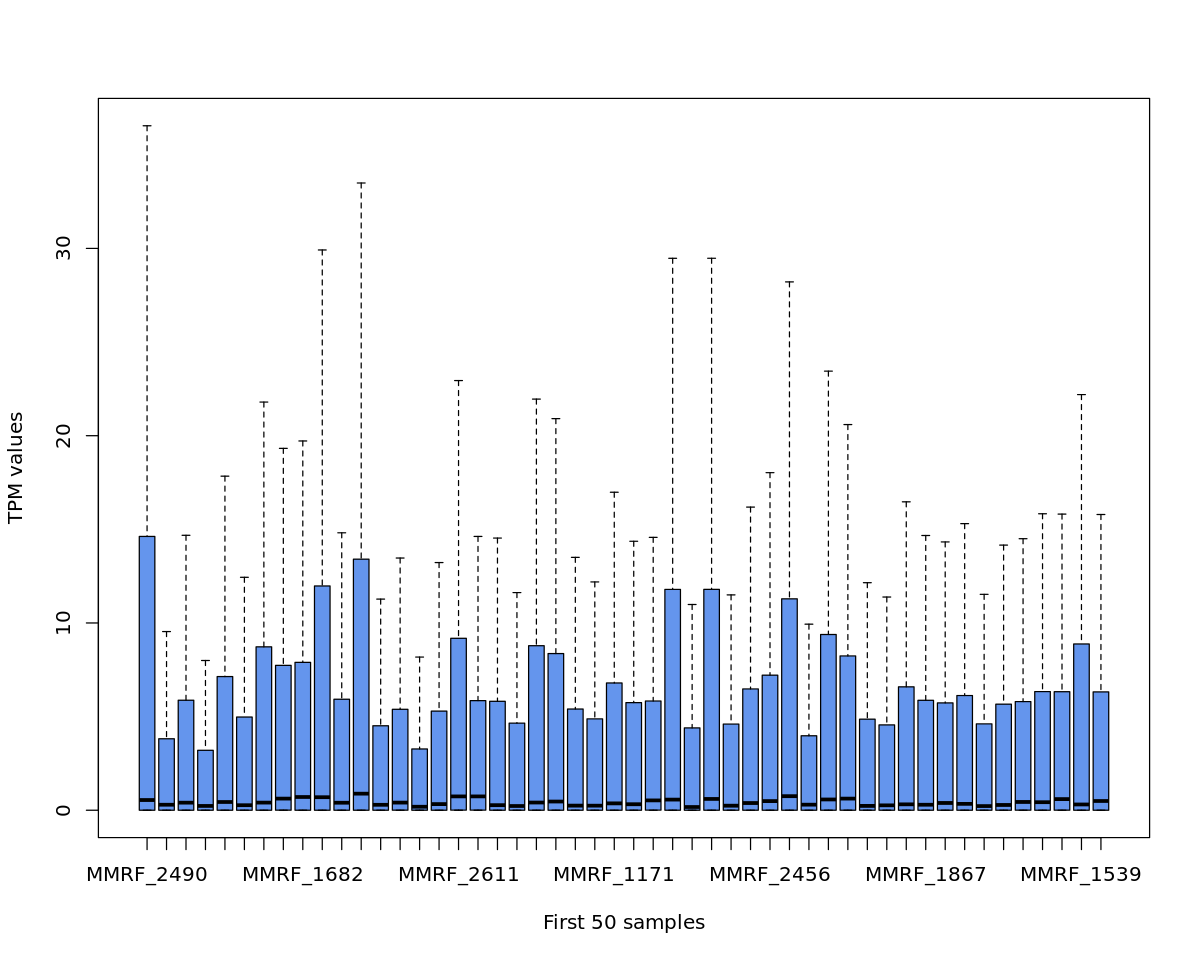

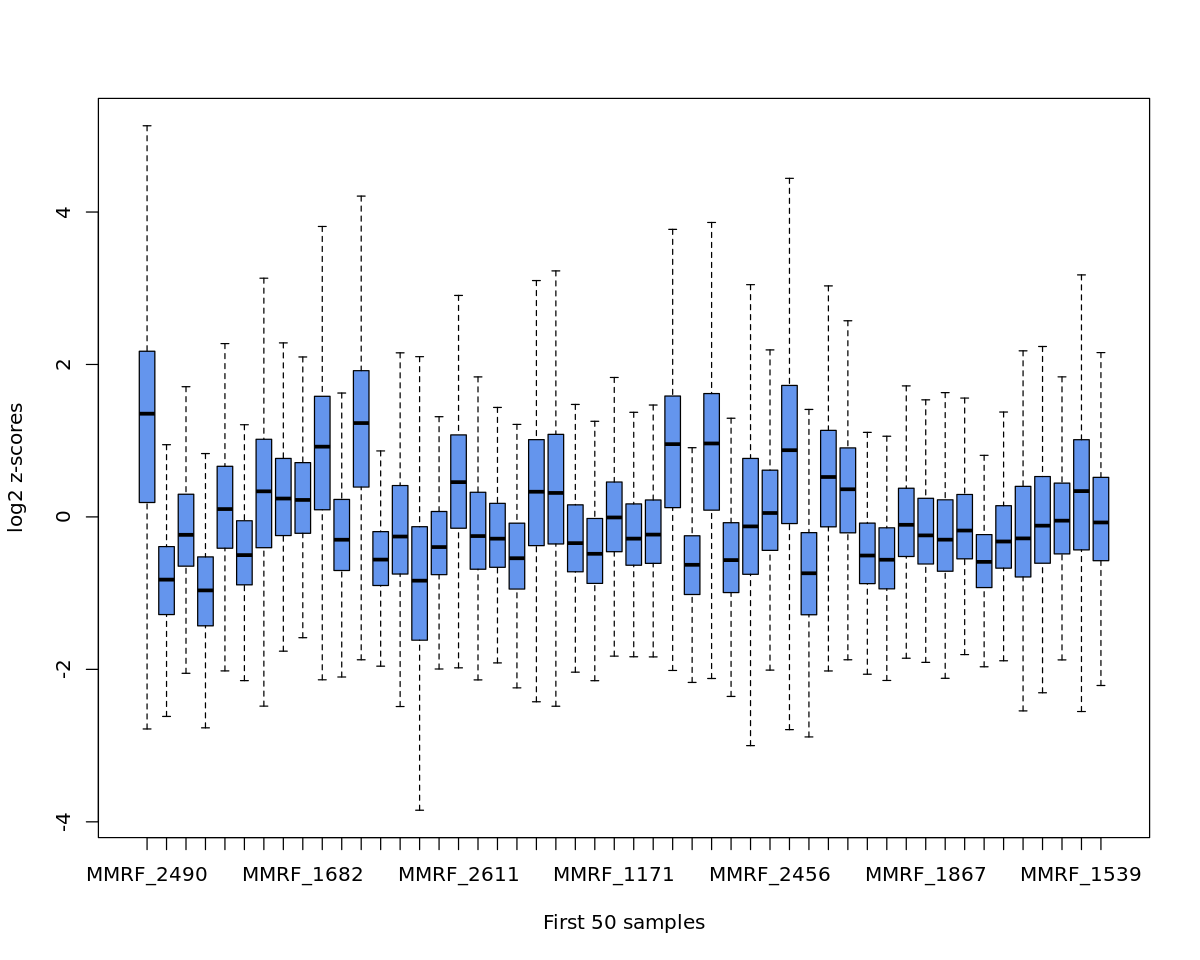

In [4]:
options(repr.plot.width=10, repr.plot.height=8)

# check if there are NA values in the expression matrix
if(anyNA(edata)) print("There are NAs in the expression matrix.")

# plot input TPM values to check if the expression data needs filtering and scaling 
# for simplicity plot just first 50 samples
boxplot(edata[,1:50],outline=FALSE,col="cornflowerblue",
        #main="Car Milage Data",
        xlab="First 50 samples", ylab="TPM values")

# remove genes with no expression in more 50% of samples
fif <- dim(edata)[2]/2
no.exp.count <- apply(edata, 1, function(x) sum(which(x == 0)))
edataf = edata[-no.exp.count,]  
                      
# filter genes based on dispersion between samples
gene.iqr <- apply(edataf, 1, IQR)                   
#plot(density(gene.iqr)) 
edataf = edataf[which(gene.iqr > 0.1),] # it removes ~half of the genes
                                            
# log transform the expression data to Z scores
gexp=log2(edataf+1)

# transform the expression data to Z scores
gexpn <- t(scale(t(gexp)))

# Plot input TPM values after filtering and scaling 
# for simplicity plot just first 50 samples
boxplot(gexpn[,1:50],outline=FALSE,col="cornflowerblue",
        xlab="First 50 samples", ylab="log2 z-scores")
                       

In [5]:
# convert entrez ids to gene names
# ~1k out of 24128 entrez ids dont have their correponsing hgnc symbols
suppressMessages(
ensembl <- biomaRt::useEnsembl(
  biomart = "genes",
  dataset = "hsapiens_gene_ensembl"
))
# conversion
biomart_res <- biomaRt::getBM(
  attributes = c("entrezgene_id", "external_gene_name","hgnc_symbol"),
  filters = c("entrezgene_id"),
  mart = ensembl,
  values = rownames(edata)
)

Unsupervised expolaratory analysis - clustering and PCA of gene expression
---------------------

I performed hierarchical clustering and principal component analysis on the top 500 most variable genes to find if there are any global patterns or batch effects.


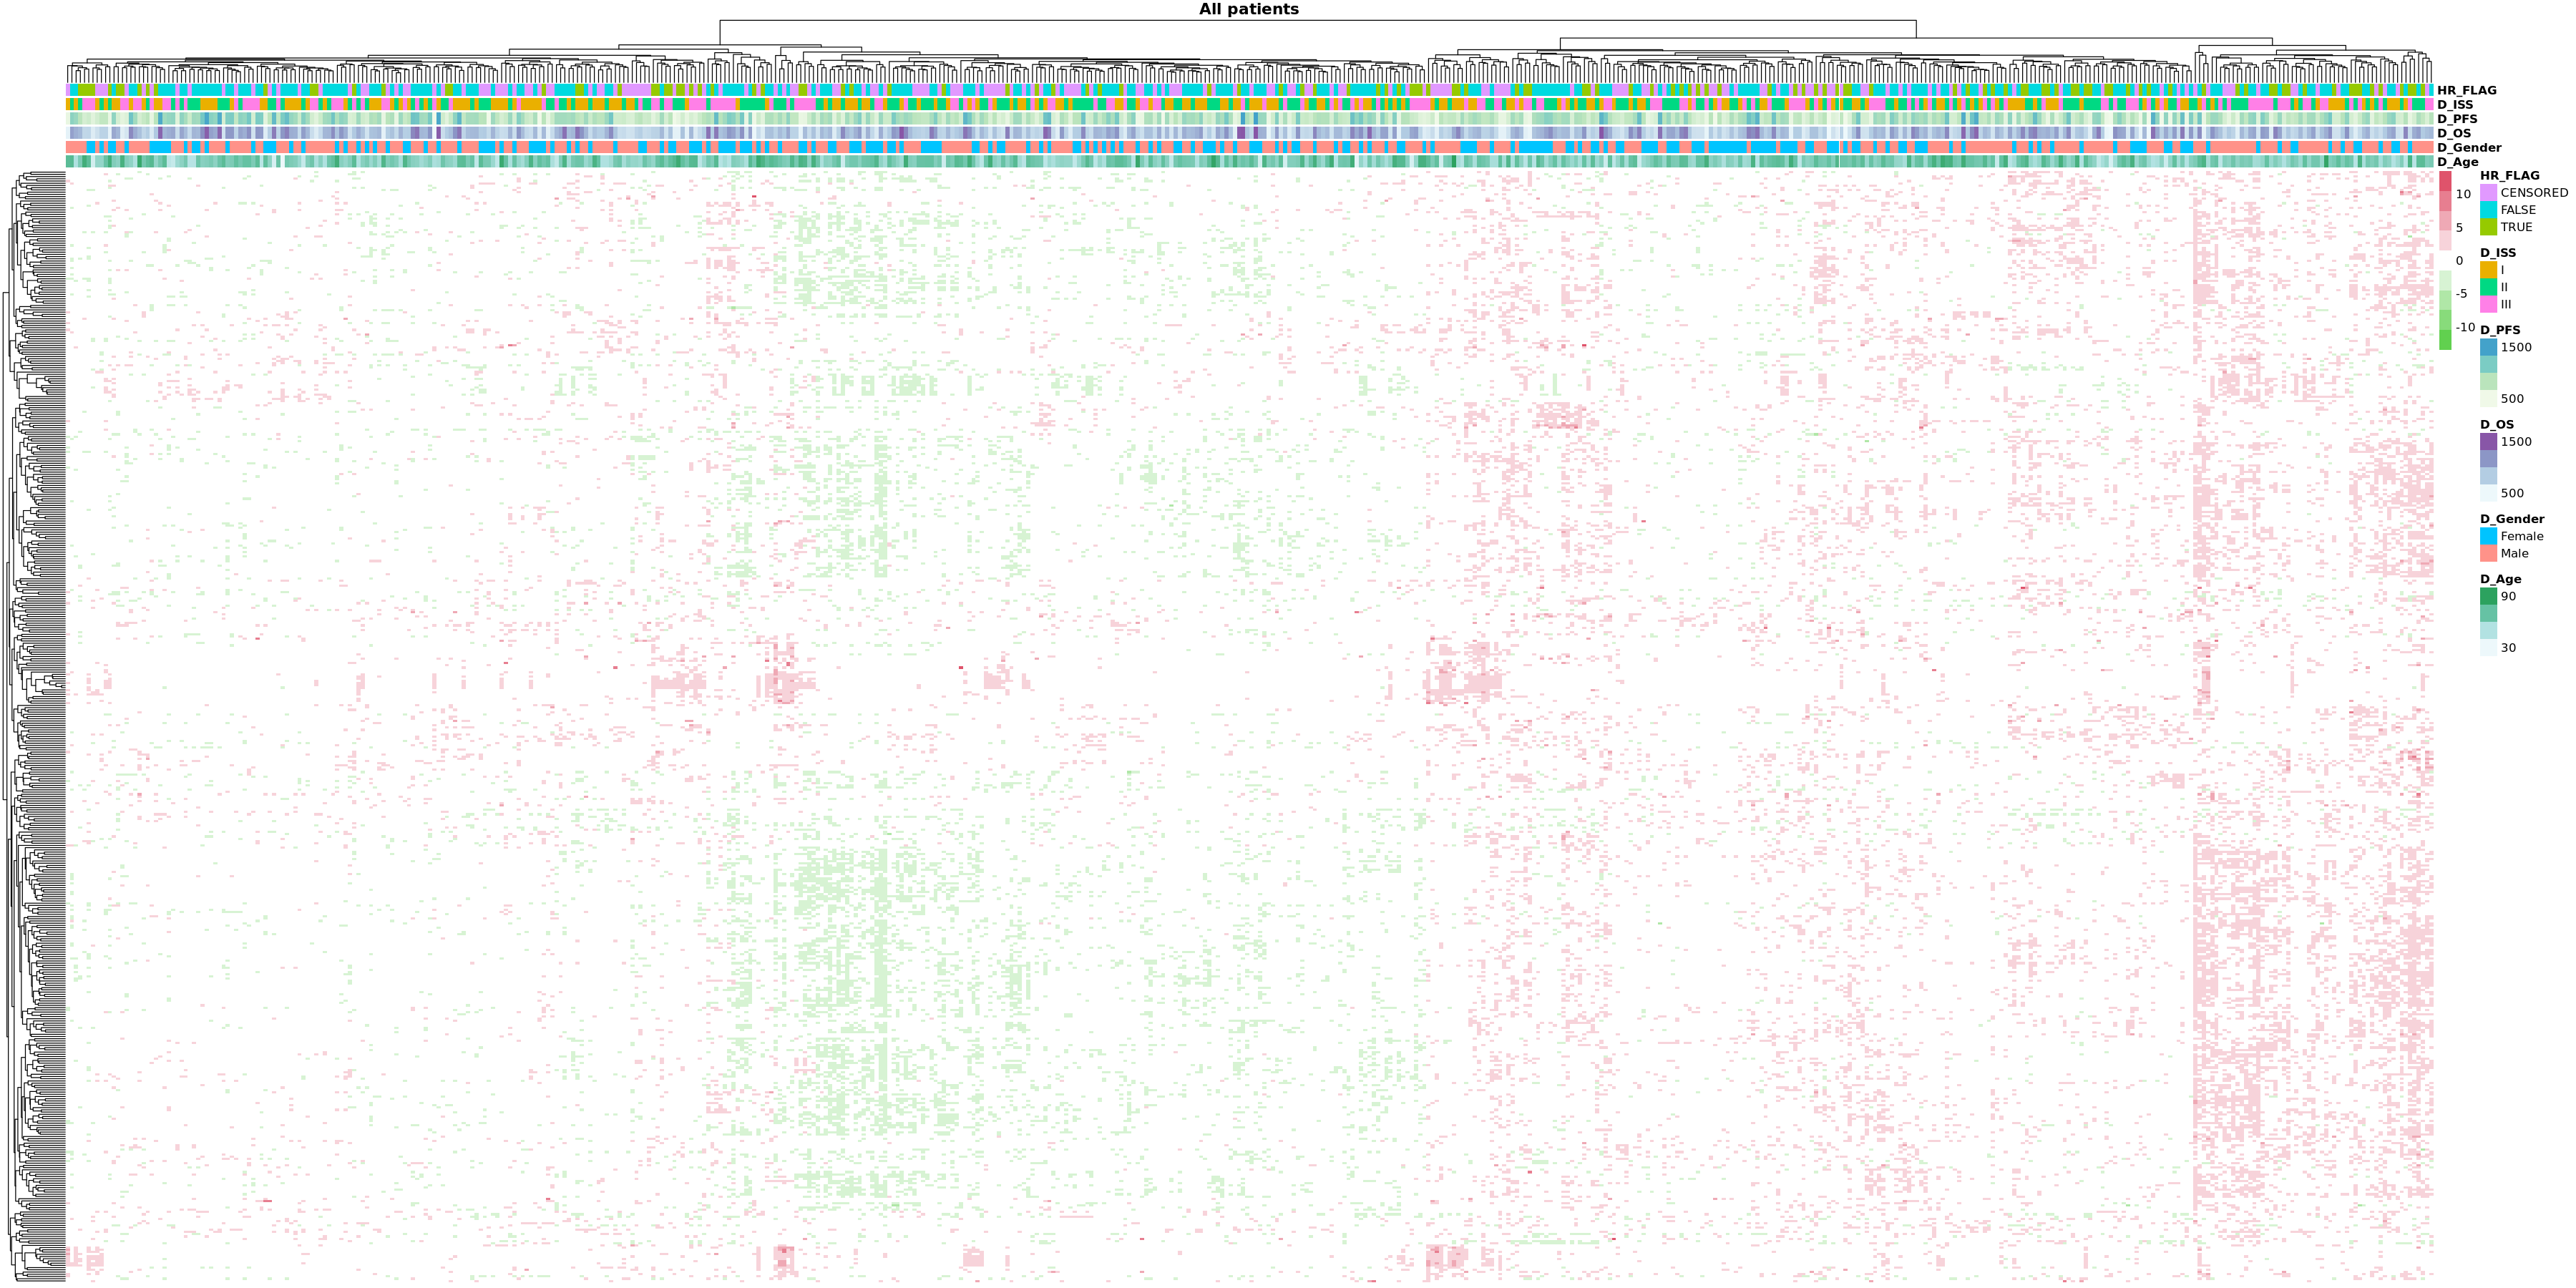

In [6]:
# compute variance of each gene across samples
V <- apply(gexpn, 1, var)

# sort the results by variance in decreasing order and select the top 100 genes 
selectedGenes <- names(V[order(V, decreasing = T)][1:500])
annot_sel_col <- c("D_Age", 
                   "D_Gender", 
                   "D_OS",
                   "D_PFS", 
                   "D_ISS", 
                   "HR_FLAG"
                  )
colData <- annot_data[which(colnames(annot_data) %in% annot_sel_col)]
rownames(colData) = annot_data$Patient

options(repr.plot.width=30, repr.plot.height=15)
colramp = colorRampPalette(c(3,"white",2))(9)
pheatmap(gexpn[selectedGenes,], 
         scale = 'row', 
         show_rownames = FALSE, 
         show_colnames = FALSE, 
         annotation_col = colData,
         col=colramp,
         main="All patients")

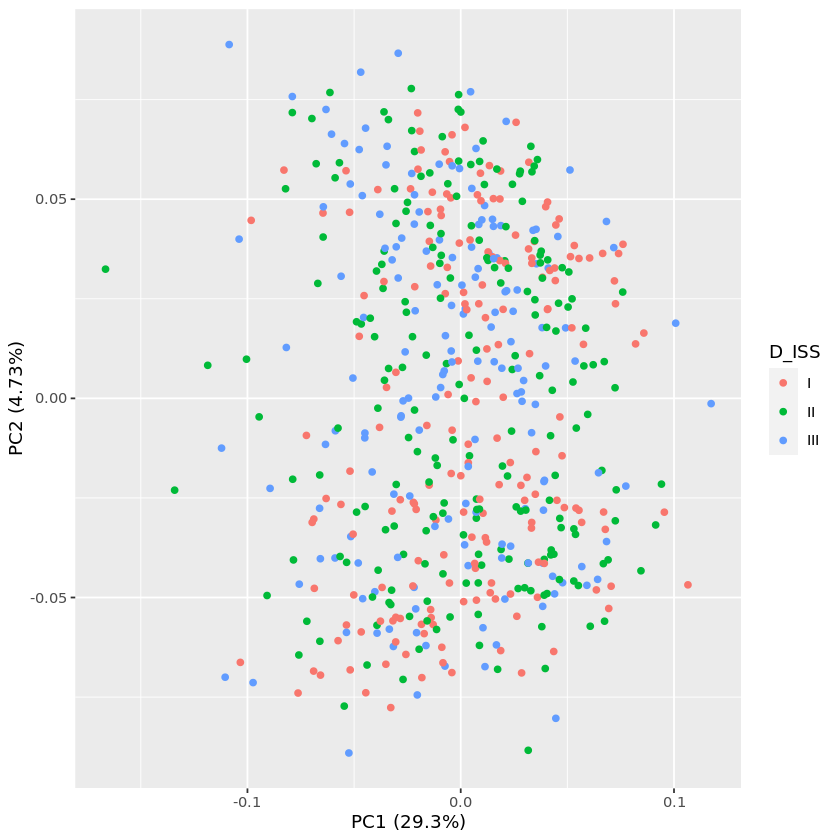

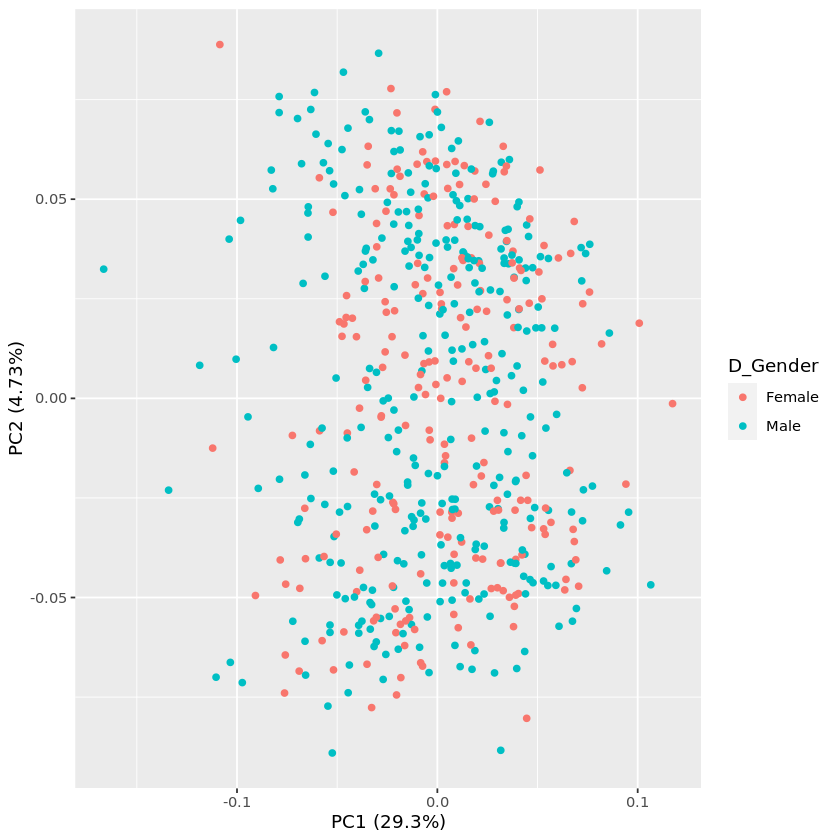

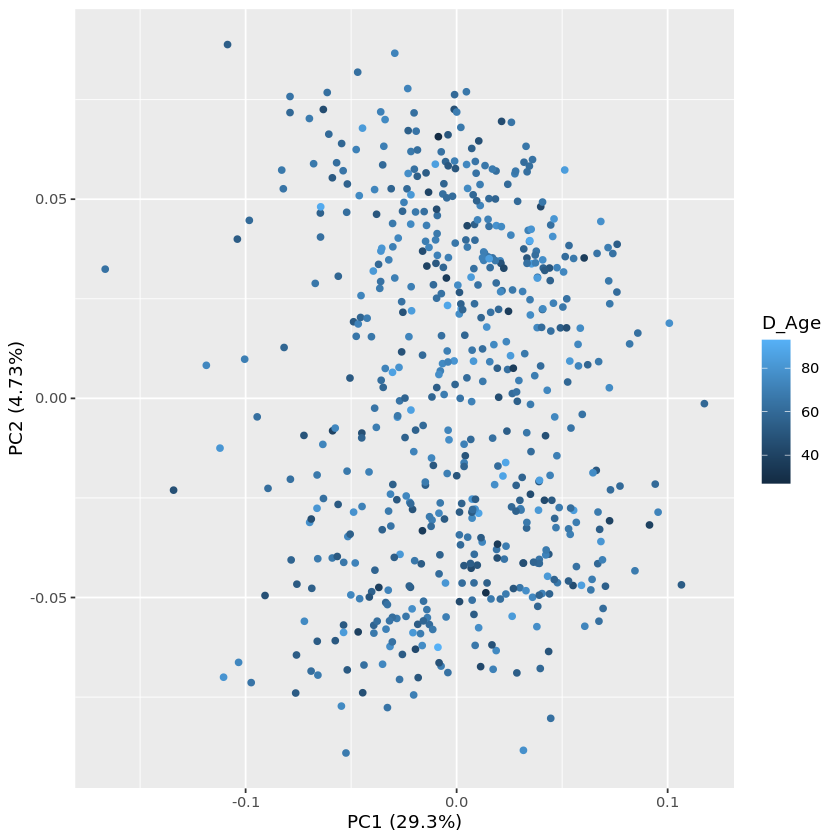

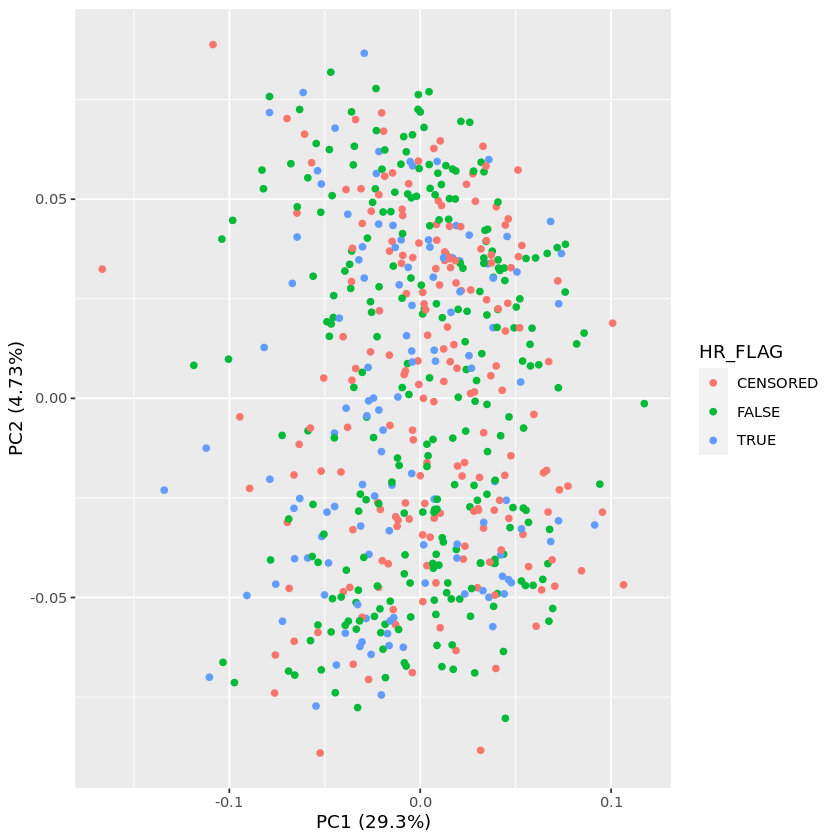

In [7]:
options(repr.plot.width=7, repr.plot.height=7)

# compute PCA 
pcaResults <- prcomp(t(gexpn), center = FALSE)
 
# plot PCA
autoplot(pcaResults, data = annot_data, colour = 'D_ISS')
autoplot(pcaResults, data = annot_data, colour = 'D_Gender')
autoplot(pcaResults, data = annot_data, colour = 'D_Age')
autoplot(pcaResults, data = annot_data, colour = 'HR_FLAG')

Modeling
---------------------------------------------------------
Next, I developed a few models for predicting the risk of dying or relapsing of newly diagnosed multiple myeloma patients from baseline clinical and/or expression data. I performed a baseline Cox proportional hazards model known from the literature that uses clinical variables age and ISS stage (https://doi.org/10.1038/s41375-020-0742-z). In my second model, instead of the Cox proportional hazards I used random survival forests method (https://www.randomforestsrc.org/articles/survival.html) and also used age and ISS as explanatory variables. My third model is inspired by the second place model from the multiple myeloma data challange that used a univariate approach to rank gene for feature selection in building expression based models (https://doi.org/10.1038/s41375-020-0742-z) - a four feature Cox proportional hazards model using variable age, ISS stage and expression of 
PHF19 and MMSE genes. In my fourth model, I used LASSO regularization for Cox model to select for genes that contribute to the prediction the most together with variables: age and ISS stages. In my fifth model, instead of using all genes for modelling, I selected genes that are reported to be associated with multiple myeolma based on a review publication in Nature on multiple myeloma (https://doi.org/10.1038/nrdp.2017.46). Lastly, I compared all the models using C-index and pick the best one that is the third model. I saved the results as a RDS file.

My steps:
1. Baseline Cox model: age + ISS
2. Random survival forests model: age + ISS
3. Cox model: age + ISS + expression of PHF19 and MMSE genes
4. Cox model: age + ISS + selected gene expressions selected from the LASSO based cox model
5. Cox model: age + ISS + selected gene expressions from gene pathways known to be associated with multiple myeloma
6. Assess performance of all models and pick the best one
7. Save the best model

Random survival forests model: age + ISS
-----------


In [32]:
set.seed(123)

y = annot_data
y$time = y$D_PFS
y$status = y$D_PFS_FLAG 
input_data_iss_age = y[,c("time","status","D_ISS","D_Age")]
metrics_rsf = 0
models_rsf = list()
for (i in 1:5) {
  index <- createDataPartition(y$status, p = 0.7, list = F)
  train_data <- input_data_iss_age[index, ] # 70%
  test_data <- input_data_iss_age[-index, ] # 30%     
  
  #fit the models
  fitrsf = rfsrc(Surv(time, status) ~ D_ISS + D_Age, data = train_data, 
                 nsplit = 3, ntree = 500)
  # extract survival probability predictions
  mat_rsf = predict(fitrsf, test_data)$survival
  
  dis_time = fitrsf$time.interest
  
  #calculate the C index
  med_index = median(1:length(dis_time))
  surv_obj = Surv(test_data$time, test_data$status)
    
  #C index for RSF
  metrics_rsf[i] = Cindex(surv_obj, predicted = mat_rsf[, med_index])
  models_rsf[[i]] = fitrsf
}


Baseline Cox model: age + ISS
-------------------------------

In [10]:
get.cox.models.cindex = function(input_data, dis_time, n=5){
    metrics = 0
    models = list()
    for (i in 1:5) {

      index <- createDataPartition(input_data$status, p = 0.7, list = F)
      train_data <- input_data[index, ] # 70%
      test_data <- input_data[-index, ] # 30%     
  
      #fit the model
      fitcox = coxph(Surv(time, status) ~ ., data = train_data, x = TRUE)
      # extract survival probability predictions
      mat_cox = predictSurvProb(fitcox, test_data, dis_time)
  
      #calculate the C index
      med_index = median(1:length(dis_time))
      surv_obj = Surv(test_data$time, test_data$status)
  
      #C index for Cox
      metrics[i] = Cindex(surv_obj, predicted = mat_cox[, med_index])
      models[[i]] = fitcox
  }
    
    return(list(metrics = metrics,
                models = models))
}

d = get.cox.models.cindex(input_data_iss_age, dis_time)
metrics_baseline_cox = d$metrics
models_baseline_cox = d$models

Cox model: age + ISS + expression of PHF19 and MMSE genes
----------------------------------


In [33]:
y_annot = annot_data[,c("D_PFS","D_PFS_FLAG","D_Age","D_ISS")]
colnames(y_annot) = c("time", "status", "D_Age", "D_ISS")

x_expr = t(gexpn)
sugo.genes.entrezid = biomart_res[which(biomart_res$hgnc_symbol %in% c("PHF19", "NSD2")),]$entrezgene_id
x_expr_sugo = x_expr[,which(colnames(x_expr) %in% sugo.genes.entrezid)]
colnames(x_expr_sugo) = c("PHF19", "NSD2")

input_data_phf19mmse <- as.data.frame(cbind(y_annot, x_expr_sugo))

set.seed(123)
d = get.cox.models.cindex(input_data_phf19mmse, dis_time)
metrics_sugo = d$metrics
models_sugo = d$models

Cox model: age + ISS + selected genes expression from the LASSO based cox model
----------------------

[1] "Selected genes:"
 [1] "NQO1"       "ETV4"       "ANXA1"      "H1-6"       "JAG2"      
 [6] "RHOC"       "MAGEA1"     "ADAM11"     "MT-ND1"     "PFKP"      
[11] "ADGRB3"     "TJP1"       "NOXA1"      "SLC27A2"    "IL24"      
[16] "DUSP10"     "SPART"      "SH3YL1"     "C11orf21"   "CDON"      
[21] "WEE1"       "H3C4"       "MBL1P"      "PAGE4"      "IER2"      
[26] "LAPTM4A"    "EIF4A3"     "LIMA1"      "HHAT"       "AUNIP"     
[31] "HMGN5"      "CDCA7"      "GINS4"      "PKDCC"      "CRB3"      
[36] "PARD3B"     "KIF19"      "TIGIT"      "LINC00324"  ""          
[41] "TMEM119"    "TICAM2"     "TMPRSS9"    "C12orf75"   "CENPS-CORT"
[46] "DLG3-AS1"   "NUTM2B-AS1" "RSPH1-DT"   "MIR3648-2"  "SNORD89"   
[51] "CAPN1-AS1" 


No results to show
Please make sure that the organism is correct or set significant = FALSE



[1] "Gene set enrichment of significant genes by gprofiler2:"


NULL

Uploading data to Enrichr... Done.
  Querying GO_Molecular_Function_2020... Done.
  Querying GO_Cellular_Component_2020... Done.
  Querying GO_Biological_Process_2020... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>


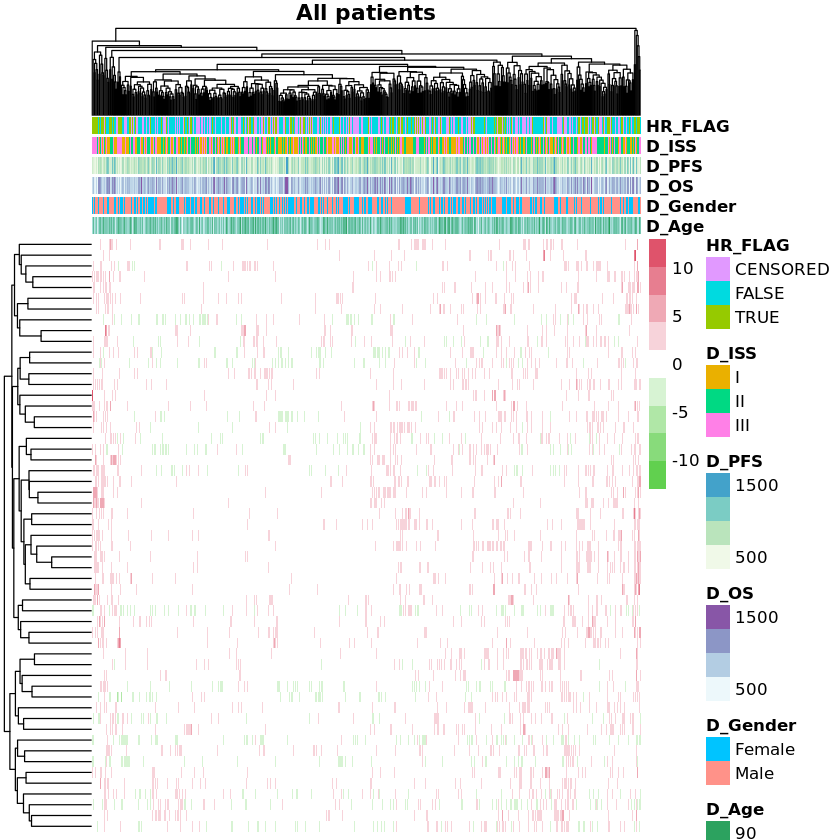

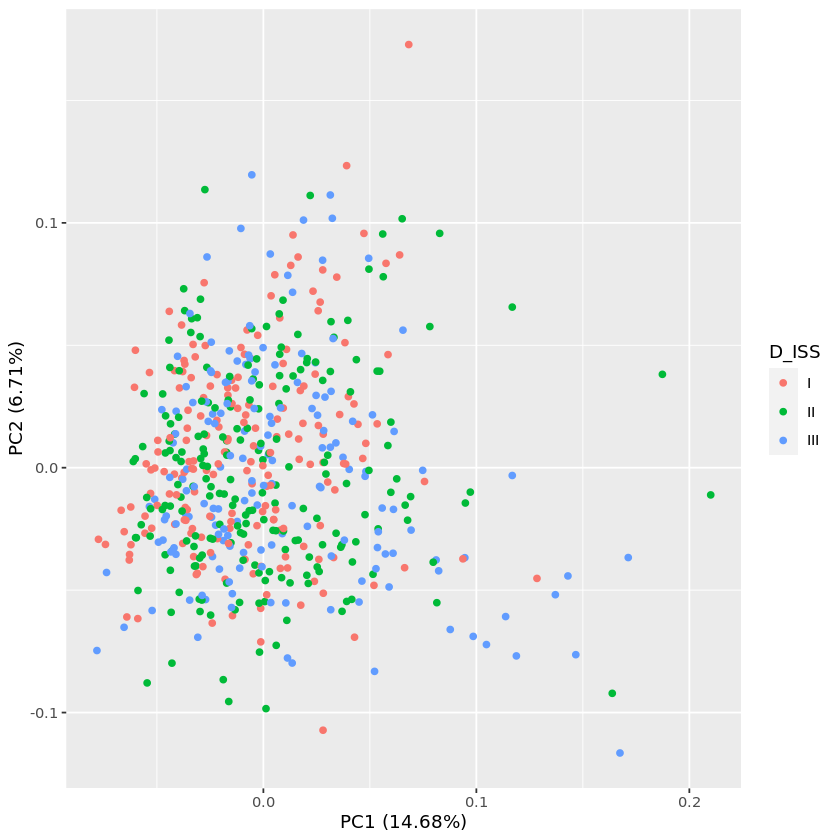

In [34]:
options(repr.plot.width=9, repr.plot.height=9)

y_annot = annot_data[,c("D_PFS","D_PFS_FLAG","D_Age","D_ISS")]
colnames(y_annot) = c("time", "status", "D_Age", "D_ISS")

# ISS factor vector convert to a binary 3-column matrix referring
# to which patient belongs to which ISS group; cv.glmnet
# doesnt accept factors as input
y_annot_bin <- model.matrix( ~ .-1, y_annot)

# get the features
x_features = cbind(y_annot_bin[,c("D_Age","D_ISSI","D_ISSII","D_ISSIII")], 
                   t(gexpn))
y_annot = y_annot_bin[,c("time", "status")]

# construct a coxnet on the entire dataset (by cv.glmnet)
# create a glmnet cox object using lasso regularization and cross-validation
set.seed(123)
glmnet.cv <- cv.glmnet(x=as.matrix(x_features), 
                       y=as.matrix(y_annot),
                       family = 'cox',
                       nfolds = 3,
                       alpha=1,
                       type.measure = "C") # LASSO
# get the glmnet model on the full dataset
glmnet.obj <- glmnet.cv$glmnet.fit

# find lambda index for the models with least partial likelihood deviance (by cv.glmnet)
optimal.lambda <- glmnet.cv$lambda.min    # For a more parsimoneous model use lambda.1se
lambda.index <- which(glmnet.obj$lambda==optimal.lambda)

# take beta for optimal lambda
optimal.beta  <- glmnet.obj$beta[,lambda.index]

# find non-zero beta coef
nonzero.coef <- abs(optimal.beta)>0
selectedBeta <- optimal.beta[nonzero.coef]

#plot(glmnet.cv)
#plot(glmnet.obj,label=TRUE)

# pick the selected features by selecting the non-zero coefficient under the best lambda selected by the model
# take only covariates for which beta is not zero
selectedVar   <- x_features[,nonzero.coef]
     
# what are the selected genes, are they related to multiple myeloma ?
selected_genes = colnames(selectedVar)[4:ncol(selectedVar)]

print("Selected genes:")
selected_genes_hgnc = unique(biomart_res[which(biomart_res$entrezgene_id %in% selected_genes),]$hgnc_symbol)
print(selected_genes_hgnc)

# functional gene set enrichment analysis os selected genes
# https://compgenomr.github.io/book/gene-expression-analysis-using-high-throughput-sequencing-technologies.html#functional-enrichment-analysis
gostres <- gost(query = selected_genes_hgnc, 
                organism = "hsapiens", ordered_query = FALSE, 
                multi_query = FALSE, significant = TRUE, exclude_iea = FALSE, 
                measure_underrepresentation = FALSE, evcodes = FALSE, 
                user_threshold = 0.05, correction_method = "g_SCS", 
                domain_scope = "annotated", custom_bg = NULL, 
                numeric_ns = "", sources = NULL, as_short_link = FALSE)
print("Gene set enrichment of significant genes by gprofiler2:")
gostres$result
# Gprofiler didn't show any interesting GEO terms of the selected genes.
# Try enrichr database to find function of the selected genes.
# Unfortunately enrichr also fails to show any terms related to the selected genes.
dbs <- c("GO_Molecular_Function_2020", "GO_Cellular_Component_2020", "GO_Biological_Process_2020")
enriched <- enrichr(selected_genes_hgnc, dbs)
head(enriched)

options(repr.plot.width=7, repr.plot.height=7)
#sort the results by variance in decreasing order and select the top 100 genes 
selectedGenes <- selected_genes
annot_sel_col <- c("D_Age", 
                   "D_Gender", 
                   "D_OS",
                   "D_PFS", 
                   "D_ISS", 
                   "HR_FLAG"
                  )
colData <- annot_data[which(colnames(annot_data) %in% annot_sel_col)]
rownames(colData) = annot_data$Patient

colramp = colorRampPalette(c(3,"white",2))(9)
pheatmap(gexpn[selectedGenes,], 
         scale = 'row', 
         show_rownames = FALSE, 
         show_colnames = FALSE, 
         annotation_col = colData,
         col=colramp,
         main="All patients")

# compute PCA 
pcaResults <- prcomp(t(gexpn)[,which(colnames(t(gexpn)) %in% selected_genes)], center = FALSE)
# plot PCA
autoplot(pcaResults, data = annot_data, colour = 'D_ISS')


set.seed(123)
# Run the cox regression on using age + ISS + selected genes
y_annot = annot_data[,c("D_PFS","D_PFS_FLAG")]
colnames(y_annot) = c("time", "status")

input_data_allsel <-  as.data.frame(cbind(y_annot, selectedVar))
set.seed(123)
d = get.cox.models.cindex(input_data_allsel, dis_time)
metrics_lasso_cox = d$metrics
models_lasso_cox = d$models


Cox model: age + ISS + selected genes expression from pathways known to be associated with multiple myeloma
-----------------------
Here I used a similar approach to the top performing method from the Genome Institute of Singapore from the Multiple myeloma data chaallenge and I used for modeeling genes from gene pathways affected by multiple myeloma. I incorporated genes described in the Nature Review on Multiple myeloma (https://doi.org/10.1038/nrdp.2017.46, Figure 3.) that include: cell cycle pathway, p53 pathway, NFKB pathway, MAPK pathway, and genes associated with multiple myeloma: MYC, MAX, IRF4, PRDM1, KRAS, NRAS, CCND1, CCND3, CCND2, DIS3, BRAF, TRAF3, PRDM1, CYLD, RB1, MAX, ACTG1, CD40, TRAF2, TRAF3, NFKB2, P100, CYLD, TNFR, CD40, TNFRSF5, TNFRSF3, TNFR, CKS1B, RB1, MAF, MAFB, ACTG1, EMC92, UAMS70. 


In [19]:
all_gene_sets = msigdbr(species = "human")
pathways.msgidb = c("KEGG_CELL_CYCLE", 
                    "HALLMARK_P53_PATHWAY", 
                    "BIOCARTA_NFKB_PATHWAY", 
                    "KEGG_MAPK_SIGNALING_PATHWAY",
                    "HALLMARK_DNA_REPAIR")
pathways.msigdb.genes = 
 all_gene_sets %>%
  dplyr::filter(gs_name %in% pathways.msgidb) %>% pull(gene_symbol, entrez_gene) 
selected_genes = unique(c("MYC", "MAX", "IRF4", "PRDM1", "KRAS", "NRAS", "CCND1", "CCND3", "CCND2", "DIS3", "BRAF", "TRAF3",
                   "PRDM1", "CYLD", "RB1", "MAX", "ACTG1", "CD40", "TRAF2", "TRAF3", "NFKB2", "P100", "CYLD", "TNFR",
                   "CD40", "TNFRSF5", "TNFRSF3", "TNFR", "CKS1B", "RB1", "MAF", "MAFB", "ACTG1", "EMC92", "UAMS70"
                   ))
sel.genes.pathways <- unique( c(pathways.msigdb.genes, selected_genes) )
pathways.genes.entrezid = biomart_res[which(biomart_res$hgnc_symbol %in% sel.genes.pathways),]$entrezgene_id


In [35]:
options(repr.plot.width=7, repr.plot.height=7)

set.seed(123)

y_annot = annot_data[,c("D_PFS","D_PFS_FLAG","D_Age","D_ISS")]
colnames(y_annot) = c("time", "status", "D_Age", "D_ISS")

# ISS factor vector convert to a binary 3-column matrix referring
# to which patient belongs to which ISS group; cv.glmnet
# doesnt accept factors as input
y_annot_bin <- model.matrix( ~ .-1, y_annot)

# get the features
x_expr = t(gexpn)
x_expr_pathways = x_expr[,which(colnames(x_expr) %in% pathways.genes.entrezid)]
x_features = cbind(y_annot_bin[,c("D_Age","D_ISSI","D_ISSII","D_ISSIII")], 
                   x_expr_pathways)
y_annot = y_annot_bin[,c("time", "status")]

# construct a coxnet on the entire dataset (by cv.glmnet)
# create a glmnet cox object using lasso regularization and cross-validation
set.seed(123)
glmnet.cv <- cv.glmnet(x=as.matrix(x_features), 
                       y=as.matrix(y_annot),
                       family = 'cox',
                       nfolds = 3,
                       alpha=1,
                       type.measure = "C") # LASSO
# get the glmnet model on the full dataset
glmnet.obj <- glmnet.cv$glmnet.fit

# find lambda index for the models with least partial likelihood deviance (by cv.glmnet)
optimal.lambda <- glmnet.cv$lambda.min    # For a more parsimoneous model use lambda.1se
lambda.index <- which(glmnet.obj$lambda==optimal.lambda)

# take beta for optimal lambda
optimal.beta  <- glmnet.obj$beta[,lambda.index]

# find non-zero beta coef
nonzero.coef <- abs(optimal.beta)>0
selectedBeta <- optimal.beta[nonzero.coef]

#plot(glmnet.cv)
#plot(glmnet.obj,label=TRUE)

# pick the selected features by selecting the non-zero coefficient under the best lambda selected by the model
# take only covariates for which beta is not zero
selectedVar_pathways   <- x_features[,nonzero.coef]


sel_entrezids = colnames(selectedVar_pathways)[4:ncol(selectedVar_pathways)]
pathways.genes.sel = biomart_res[which(biomart_res$entrezgene_id %in% sel_entrezids),]$hgnc_symbol
print("Selected genes from the pathways associated with multiple myeloma:")
pathways.genes.sel

# run the cox regression on using age + ISS + selected genes
y_annot = annot_data[,c("D_PFS","D_PFS_FLAG")]
colnames(y_annot) = c("time", "status")

input_data_pathways <- as.data.frame(cbind(y_annot, selectedVar_pathways))
set.seed(123)
d = get.cox.models.cindex(input_data_pathways, dis_time)
metrics_lasso_cox_pathways = d$metrics
models_lasso_cox_pathways = d$models


[1] "Selected genes from the pathways associated with multiple myeloma:"


[1] "FLNA"   "JAG2"   "STMN1"  "PLK1"   "RAC3"   "DUSP10" "WEE1"   "CDC7"

Assess performance of all models and pick the best one
-------------------------

Assess performances of models based on the C-index. The larger the C index, the better the model prediction.

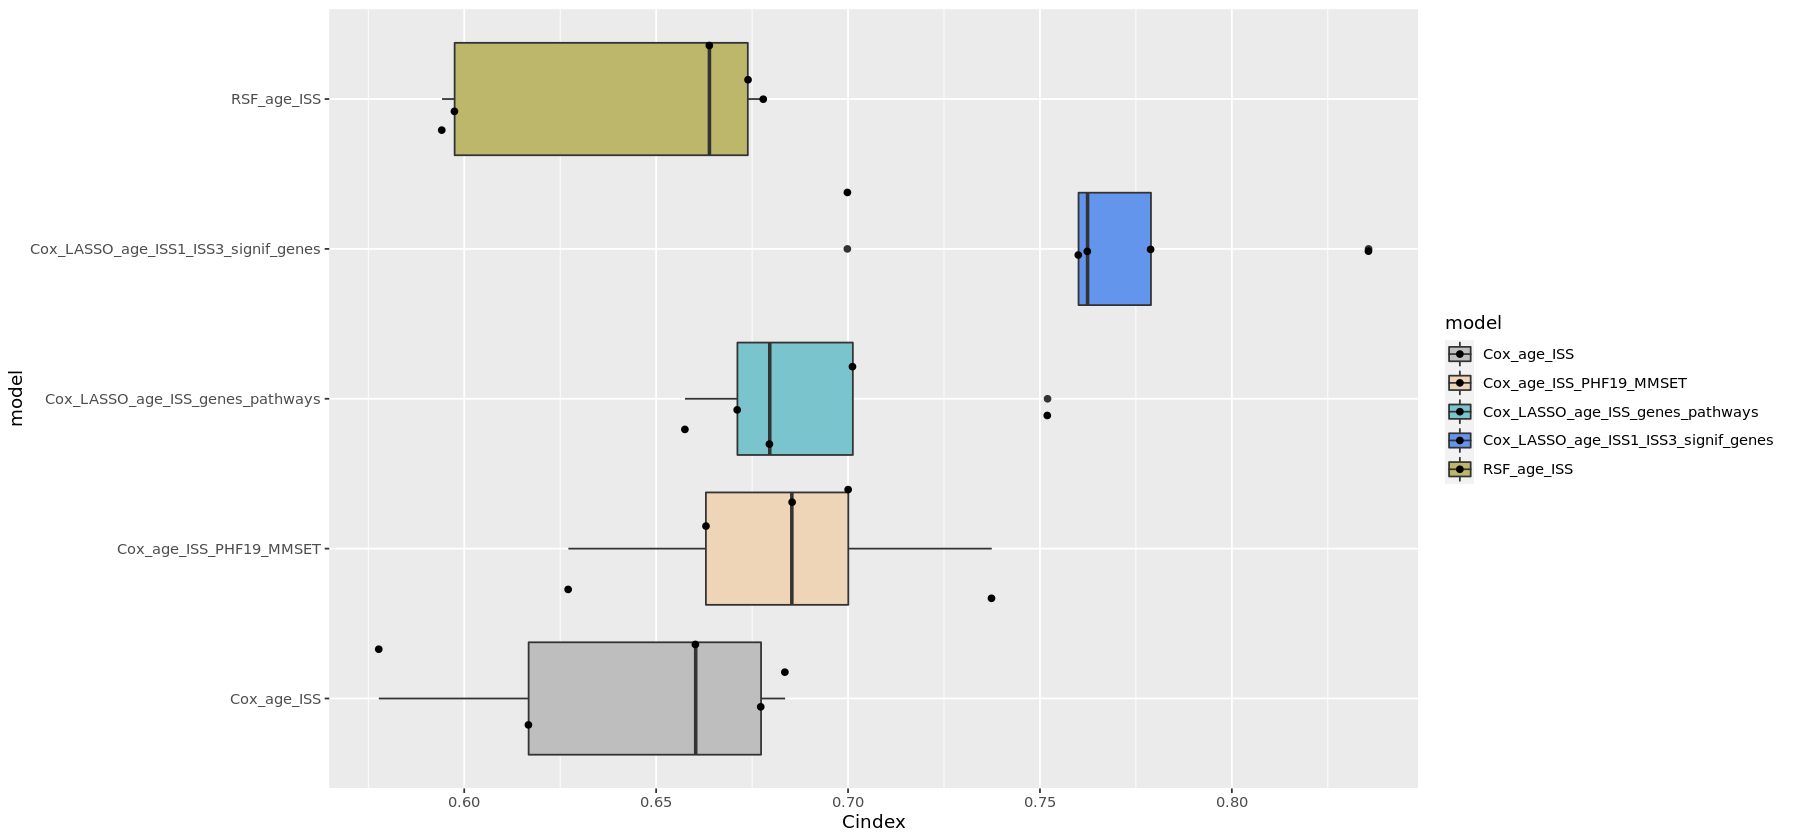

In [30]:
options(repr.plot.width=15, repr.plot.height=7)

data_CI = data.frame('Cindex' = c(metrics_baseline_cox, # Baseline Cox model: age + ISS
                                  metrics_rsf, # Random survival forests model: age + ISS
                                  metrics_lasso_cox,  # Cox model: age + ISS + selected gene expressions selected from the LASSO based cox model
                                  metrics_sugo, # Cox model: age + ISS + expression of PHF19 and MMSE genes
                                  metrics_lasso_cox_pathways # Cox model: age + ISS + selected gene expressions from gene pathways known to be associated with multiple myeloma
                                 ), 
                     'model' = c(rep('Cox_age_ISS', 5), 
                                 rep('RSF_age_ISS', 5),
                                 rep('Cox_LASSO_age_ISS_all_genes', 5),
                                 rep('Cox_age_ISS_PHF19_MMSET', 5),
                                 rep('Cox_LASSO_age_ISS_genes_pathways', 5)
                                ))

ggplot(data_CI, aes(x = model, y = Cindex, fill = model)) +
  geom_boxplot() +
  coord_flip()+
  scale_fill_manual(values = c("grey", "bisque2", "cadetblue3","cornflowerblue","darkkhaki"))+
  geom_jitter()

Assess performances of models based on the Kaplan–Meier curves.

Continuous risk predictions scores of each sample were thresholded to create high risk classifications. The threshold of a given model was calculated by generating sample level  predictions in the training data. The threshold was defined as the cutpoint that maximized the logrank statistic comparing above and below the threshold to their true high-risk status. Continuous predictions for validation data were computed by applying the above trained Cox proportional hazards model to them. These values were dichotomized into high and low risk according to whether the prediction was above or below, respectively, the threshold.

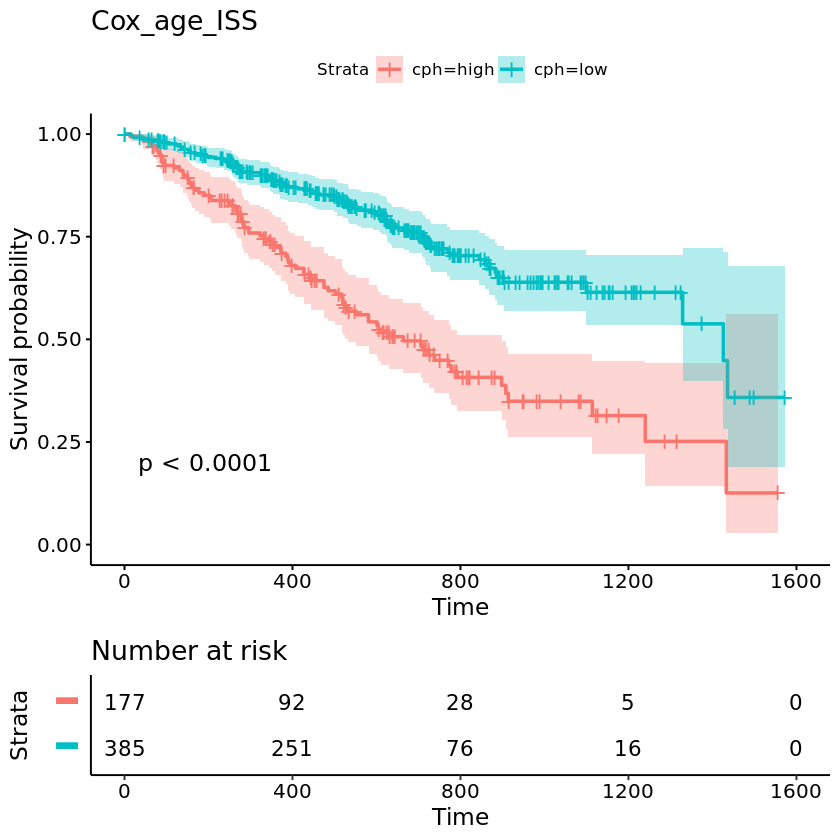

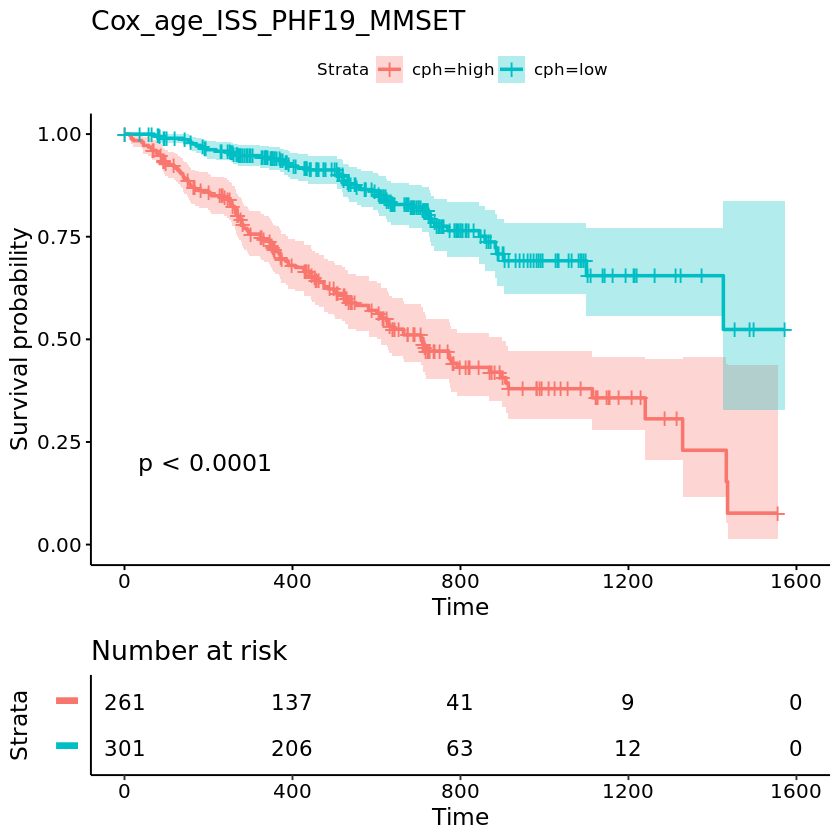

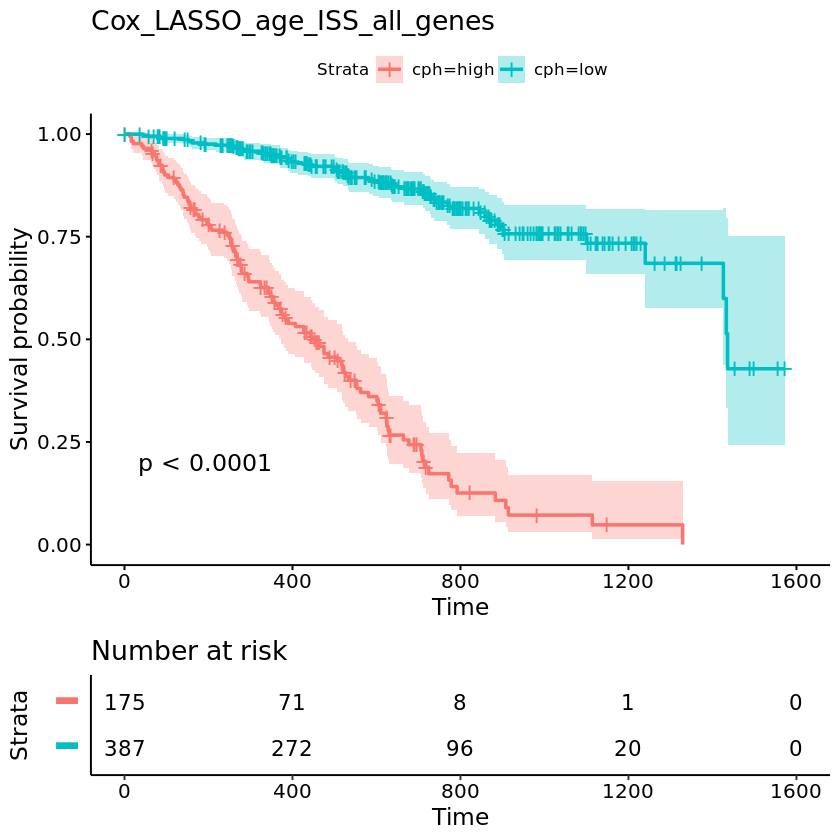

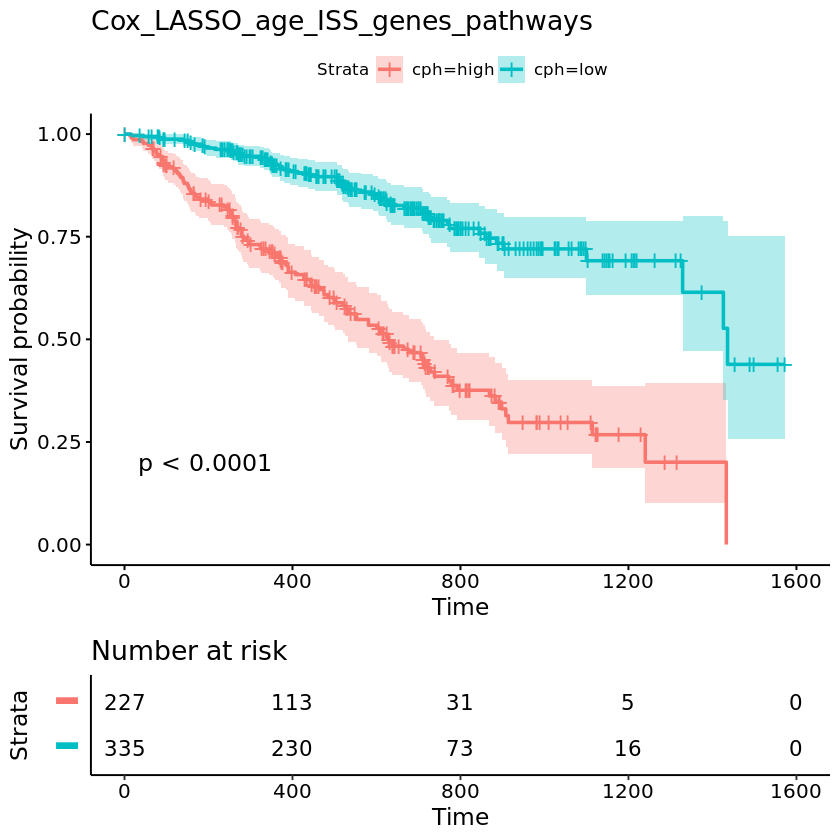

In [56]:
membership.pred = function(model, data){
    
    require(survminer)
    
    pred <- unname(predict(model, newdata = data, type = "risk"))
    data_cph <- cbind(data, cph=pred)

    # Calculate a threshold for the Cox proportional hazards model: using the t = 0 
    mt.formula <- as.formula(paste("Surv(time, status)", "~", "cph", sep = " "))
    mt <- maxstat.test(mt.formula, data=data.frame(data_cph), 
                       smethod="LogRank", pmethod="none")
    threshold <- as.numeric(mt$estimate)

    data_cph$high.risk <- unlist(apply(data_cph[, c("status", "time")], 1,
                            function(row) ifelse((row[1] == 1) && (row[2] < 18*(365.25/12)),
                                                 "high-risk", "low-risk")))
    data_cph$inferred.high.risk <- data_cph$cph > threshold
    
    # test significance between actual risks and predicted risks                           
    #fisher.test(data_cph$high.risk, 
    #            data_cph$inferred.high.risk)
    
    # plot boxplots of actual high-risk and predicted                                 
    #library(ggplot2)
    #g <- ggplot(data = data_cph, aes(x = high.risk, y = cph))
    #g <- g + geom_boxplot()
                                       
    fit <- survfit(Surv(time, status) ~ cph,
               data = data_cph)
                                                                                 
    dat.cut = surv_cutpoint(
      data_cph,
      time = "time",
      event = "status",
      c("cph"),
      minprop = 0.1,
      progressbar = FALSE
    )
    #plot density and the cut off
    #plot(dat.cut, "cph", palette = "npg")                                                                                       
                                            
    surv.cat <- surv_categorize(dat.cut)
    fit.cph <- survfit(Surv(time, status) ~ cph,
                       data = surv.cat)      
                                       
    return(list(model = fit.cph,
                data.cat = surv.cat))        
                                            
}

plot.survival = function(myfit, title=""){
    require(survminer) 
    ggsurvplot(
       myfit$model,                     
       data = myfit$data.cat,
       risk.table = TRUE,       # show risk table.
       pval = TRUE,             # show p-value of log-rank test.
       conf.int = TRUE,         # show confidence intervals for 
                            # point estimaes of survival curves.
      risk.table.y.text.col = T, # colour risk table text annotations.
      risk.table.y.text = FALSE, # show bars instead of names in text annotations
                            # in legend of risk table
      title=title
    ) 
}
 
# Baseline Cox model: age + ISS                                      
fit_baseline_cox = membership.pred(models_baseline_cox[[which.max(metrics_baseline_cox)]], 
                                   input_data_iss_age)   
plot.survival(fit_baseline_cox,
              "Cox_age_ISS")                                       

# Cox model: age + ISS + expression of PHF19 and MMSE genes                                       
fit_sugo = membership.pred(models_sugo[[which.max(metrics_sugo)]], 
                           input_data_phf19mmse)   
plot.survival(fit_sugo,
              "Cox_age_ISS_PHF19_MMSET") 
                                       
# Cox model: age + ISS + selected gene expressions selected from the LASSO based cox model                                       
fit_lasso_cox = membership.pred(models_lasso_cox[[which.max(metrics_lasso_cox)]], 
                           input_data_allsel)   
plot.survival(fit_lasso_cox,
              "Cox_LASSO_age_ISS_all_genes") 
                
# Cox model: age + ISS + selected gene expressions from gene pathways known to be associated with multiple myeloma                                       
fit_lasso_cox_pathways = membership.pred(models_lasso_cox_pathways[[which.max(metrics_lasso_cox_pathways)]], 
                           input_data_pathways)   
plot.survival(fit_lasso_cox_pathways,
              "Cox_LASSO_age_ISS_genes_pathways") 
                                                                                            
                                       

Save the best model
-------------------------

In my opinion, based on the highest C index, and the best distinction of the survival probability between high-risk and low-risk sample on the Kaplan–Meier curves, the best model is the LASSO based Cox proportional hazards model using features: age, ISS and expression of all genes, and then narrowing down to genes with non-zero coefficients (printed below). I pick this model even though I couldn't find any meaningful GEO terms associated with these genes with multiple myeloma by just using gprofiler or renrichr tools.

In [60]:
data.frame(features=c("D_ISS","D_Age",selected_genes_hgnc))

saveRDS(models_lasso_cox[[which.max(metrics_lasso_cox)]], 
        "./Model_KWrreczycka.RDS")

features
<chr>
D_ISS
D_Age
NQO1
ETV4
ANXA1
H1-6
JAG2
RHOC
MAGEA1


In [61]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] survminer_0.4.9       ggpubr_0.4.0          enrichR_3.1          
 [4] gprofiler2_0.2.1      msigdbr_7.5.1         pec_2022.05.04       
 [7] prodlim_2019.11.13    randomForestSRC_3.1.1 caret_6.0-93         
[10] lattice_0.20-45       SurvMetrics_0.5.0     dichromat_2.0-0.1    
[13] pheatmap_1.0.12       m